In [ ]:
# Binary Classification model in neural network is like logistic regression in simple standalone models (target is 0-1)
# a Binary Classification model for breast cancer

In [20]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
# ucimlrepo: UCI Machine Learning Repository
# fetch_ucirepo: downloads datasets directly from the UCI Machine Learning Repository

# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# convert dataset from ucimlrepo.dotdict.dotdict to pandas dataframe
X = breast_cancer_wisconsin_diagnostic.data.features  # .data and .features are not built-in Python attributes or special syntax. They are just attribute names that were chosen by the developers of the UCI ML Repository package for their data structure.
y = breast_cancer_wisconsin_diagnostic.data.targets
df = pd.concat([X, y], axis=1)  # join columns

# pick 200 of each benign and malignant samples and put them in 1 table
df_benign = df[df['Diagnosis'] == 'B'].sample(n=200, random_state=42)
df_malignant = df[df['Diagnosis'] == 'M'].sample(n=200, random_state=42)

balances_data = pd.concat([df_benign, df_malignant], axis=0)  # join type default is axis=0: join rows (Stacks the DataFrames vertically (on top of each other))


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

X = balances_data.drop('Diagnosis', axis=1)
y = balances_data['Diagnosis']
y = y.map({'B': 0, 'M': 1})  # Convert the targets to binary labels
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # cause we just have 400 rows we just do train and test

X_train = StandardScaler().fit_transform(X_train)  # we standardize after splitting to make the evaluation more realistic (to avoid overly optimistic performance estimates)
X_test = StandardScaler().fit_transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)  # For CrossEntropyLoss, y_batch should be Long type, not Float:
y_test = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

In [22]:
# In practice, simple networks often use nn.Sequential, while more complex architectures (like ResNet) use separate layer definitions (nn.Linear) for more control.
# check other files for nn.Sequential

In [23]:
import torch.nn as nn
import torch.optim as optim

class ClassificationNet(nn.Module):
    def __init__(self, input_units=30, hidden_units=64, output_units=2):
        super().__init__()
        self.fc1 = nn.Linear(input_units, hidden_units)  # nn.Linear: It's a single layer that performs a linear transformation: y = xA^T + b (unlike nn.Sequential that  can hold MULTIPLE layers in sequence)
        self.fc2 = nn.Linear(hidden_units, output_units)
        # fc: Fully Connected Layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ClassificationNet(input_units=30, hidden_units=64, output_units=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
epochs = 10
train_losses = []  # Store training loss for each epoch
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred_train = model(X_batch)
        loss = criterion(pred_train, y_batch)  # gives me loss for each batch
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)  # average loss among batches in this epoch  
    # len(train_loader): number of batches in your training dataset
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            pred_test = model(X_batch)
            loss = criterion(pred_test, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')




Epoch [1/10], Train Loss: 0.3477, Test Loss: 0.1193
Epoch [2/10], Train Loss: 0.1425, Test Loss: 0.0699
Epoch [3/10], Train Loss: 0.1054, Test Loss: 0.0623
Epoch [4/10], Train Loss: 0.0892, Test Loss: 0.0663
Epoch [5/10], Train Loss: 0.0822, Test Loss: 0.0489
Epoch [6/10], Train Loss: 0.0757, Test Loss: 0.0537
Epoch [7/10], Train Loss: 0.0693, Test Loss: 0.0385
Epoch [8/10], Train Loss: 0.0693, Test Loss: 0.0444
Epoch [9/10], Train Loss: 0.0613, Test Loss: 0.0596
Epoch [10/10], Train Loss: 0.0565, Test Loss: 0.0376


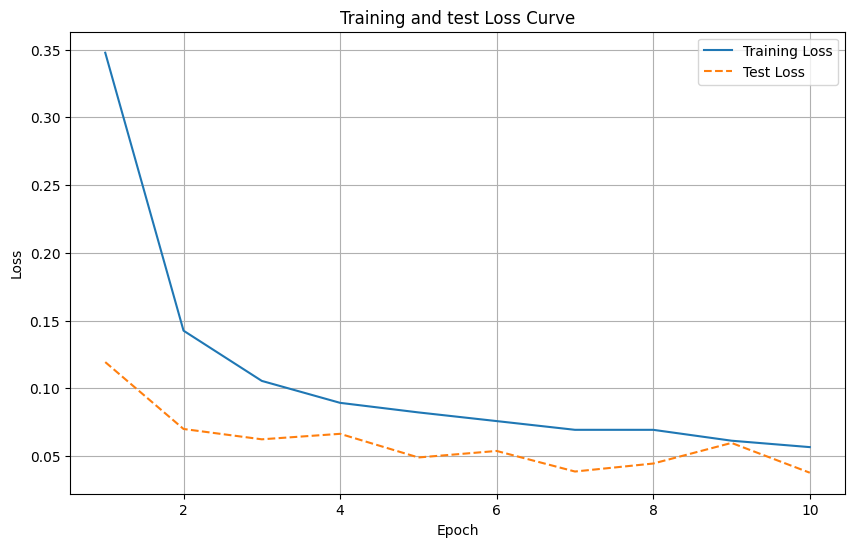

In [25]:
# Vizualize the training and test loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
# range(1, epochs + 1): x axis => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# train_losses: y axis
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()